In [1]:
#import important programs
import numpy as np
import pandas as pd
import sqlalchemy as sal
from sqlalchemy import create_engine
import pymysql
import pandas_profiling as pp

D:\Users\jryba\anaconda3\envs\DataAnalyticsCourse\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Loading data
credit = pd.read_csv('credit1.csv')
credit = credit.drop(columns='Unnamed: 0')
pd.set_option('display.max_columns',None)
credit.head()

ID  Limit_bal  Gender  Education  Marriage  Age  Pay_1  Pay_2  Pay_3  \
0   1      20000       1          3         1   24      2      2     -1   
1   2     120000       1          3         2   26     -1      2      0   
2   3      90000       1          3         2   34      0      0      0   
3   4      50000       1          3         1   37      0      0      0   
4   5      50000       2          3         1   57     -1      0     -1   

   Pay_4  Pay_5  Pay_6  Bill_Amt1  Bill_Amt2  Bill_Amt3  Bill_Amt4  Bill_Amt5  \
0     -1     -2     -2       3913       3102        689          0          0   
1      0      0      2       2682       1725       2682       3272       3455   
2      0      0      0      29239      14027      13559      14331      14948   
3      0      0      0      46990      48233      49291      28314      28959   
4      0      0      0       8617       5670      35835      20940      19146   

   Bill_Amt6  Pay_Amt1  Pay_Amt2  Pay_Amt3  Pay_Amt4  Pay_Amt5  Pay_Amt6  \
0          0         0       689         0         0         0         0   
1       3261         0      1000      1000      1000         0      2000   
2      15549      1518      1500      1000      1000      1000      5000   
3      29547      2000      2019      1200      1100      1069      1000   
4      19131      2000     36681     10000      9000       689       679   

   Default  
0        2  
1        2  
2        1  
3        1  
4        1

In [3]:
#Reindexing columns to make more sense
credit.columns = ['ID', 'Limit_bal', 'Gender', 'Education', 'Marriage', 'Age', 'Pay_Sept', 'Pay_Aug', 'Pay_Jul', 'Pay_Jun', 'Pay_May', 'Pay_Apr', 'Bill_Sept', 'Bill_Aug', 'Bill_Jul', 'Bill_Jun', 'Bill_May', 'Bill_Apr', 'Pay_Amt_Sept', 'Pay_Amt_Aug', 'Pay_Amt_Jul', 'Pay_Amt_Jun', 'Pay_Amt_May', 'Pay_Amt_Apr', 'Default']
column_names = ['ID', 'Default', 'Limit_bal', 'Gender', 'Education', 'Marriage', 'Age', 'Pay_Apr', 'Pay_May', 'Pay_Jun', 'Pay_Jul', 'Pay_Aug', 'Pay_Sept', 'Bill_Apr', 'Bill_May', 'Bill_Jun', 'Bill_Jul', 'Bill_Aug', 'Bill_Sept', 'Pay_Amt_Apr', 'Pay_Amt_May', 'Pay_Amt_Jun', 'Pay_Amt_Jul', 'Pay_Amt_Aug', 'Pay_Amt_Sept']
credit = credit.reindex(columns=column_names)
credit.head()

ID  Default  Limit_bal  Gender  Education  Marriage  Age  Pay_Apr  Pay_May  \
0   1        2      20000       1          3         1   24       -2       -2   
1   2        2     120000       1          3         2   26        2        0   
2   3        1      90000       1          3         2   34        0        0   
3   4        1      50000       1          3         1   37        0        0   
4   5        1      50000       2          3         1   57        0        0   

   Pay_Jun  Pay_Jul  Pay_Aug  Pay_Sept  Bill_Apr  Bill_May  Bill_Jun  \
0       -1       -1        2         2         0         0         0   
1        0        0        2        -1      3261      3455      3272   
2        0        0        0         0     15549     14948     14331   
3        0        0        0         0     29547     28959     28314   
4        0       -1        0        -1     19131     19146     20940   

   Bill_Jul  Bill_Aug  Bill_Sept  Pay_Amt_Apr  Pay_Amt_May  Pay_Amt_Jun  \
0       689      3102       3913            0            0            0   
1      2682      1725       2682         2000            0         1000   
2     13559     14027      29239         5000         1000         1000   
3     49291     48233      46990         1000         1069         1100   
4     35835      5670       8617          679          689         9000   

   Pay_Amt_Jul  Pay_Amt_Aug  Pay_Amt_Sept  
0            0          689             0  
1         1000         1000             0  
2         1000         1500          1518  
3         1200         2019          2000  
4        10000        36681          2000

Matching the payment and billing to the months. I noticed that the dates were backwards, so I changed the order of the columns. It took a number of iterations to get them to do so. I eventually created a separate series to reindex the columns.

In [4]:
#Add columns; age bin, credit limit bin, total bill/payment, outstanding debt
credit['Total_Bill'] = credit['Bill_Apr']+credit['Bill_May']+credit['Bill_Jun']+credit['Bill_Jul']+credit['Bill_Aug']+credit['Bill_Sept']
credit['Total_Pay_Amt'] = credit['Pay_Amt_Apr']+credit['Pay_Amt_May']+credit['Pay_Amt_Jun']+credit['Pay_Amt_Jul']+credit['Pay_Amt_Aug']+credit['Pay_Amt_Sept']
credit['Total_Pay'] = (credit['Pay_Apr']+credit['Pay_May']+credit['Pay_Jun']+credit['Pay_Jul']+credit['Pay_Aug']+credit['Pay_Sept'])
credit['Outstanding_Debt'] = credit['Total_Bill']-credit['Total_Pay_Amt']\

#binning ages
Age_Bins = pd.IntervalIndex.from_tuples([(10,20),(20,30),(30,40),(40,50),(50,60),(60,70),(70,80),(80,90)], closed='left')
credit['Age_Bins'] = pd.cut(credit['Age'],Age_Bins)
credit['Age_Bins']=credit['Age_Bins'].astype('string')
credit['Age_Bins']=credit['Age_Bins'].replace('[10, 20)','10')
credit['Age_Bins']=credit['Age_Bins'].replace('[20, 30)','20')
credit['Age_Bins']=credit['Age_Bins'].replace('[30, 40)','30')
credit['Age_Bins']=credit['Age_Bins'].replace('[40, 50)','40')
credit['Age_Bins']=credit['Age_Bins'].replace('[50, 60)','50')
credit['Age_Bins']=credit['Age_Bins'].replace('[60, 70)','60')
credit['Age_Bins']=credit['Age_Bins'].replace('[70, 80)','70')
credit['Age_Bins']=credit['Age_Bins'].replace('(80, 90)','80')
credit['Age_Bins']=credit['Age_Bins'].astype('int64')

#reindexing columns
column_names = ['ID', 'Default', 'Limit_bal', 'Gender', 'Education', 'Marriage', 'Age', 'Age_Bins', 'Pay_Apr', 'Pay_May', 'Pay_Jun', 'Pay_Jul', 'Pay_Aug', 'Pay_Sept', 'Total_Pay','Bill_Apr', 'Bill_May', 'Bill_Jun', 'Bill_Jul', 'Bill_Aug', 'Bill_Sept', 'Total_Bill', 'Pay_Amt_Apr', 'Pay_Amt_May', 'Pay_Amt_Jun', 'Pay_Amt_Jul', 'Pay_Amt_Aug', 'Pay_Amt_Sept', 'Total_Pay_Amt','Outstanding_Debt']
credit = credit.reindex(columns=column_names)
credit.head()

ID  Default  Limit_bal  Gender  Education  Marriage  Age  Age_Bins  \
0   1        2      20000       1          3         1   24        20   
1   2        2     120000       1          3         2   26        20   
2   3        1      90000       1          3         2   34        30   
3   4        1      50000       1          3         1   37        30   
4   5        1      50000       2          3         1   57        50   

   Pay_Apr  Pay_May  Pay_Jun  Pay_Jul  Pay_Aug  Pay_Sept  Total_Pay  Bill_Apr  \
0       -2       -2       -1       -1        2         2         -2         0   
1        2        0        0        0        2        -1          3      3261   
2        0        0        0        0        0         0          0     15549   
3        0        0        0        0        0         0          0     29547   
4        0        0        0       -1        0        -1         -2     19131   

   Bill_May  Bill_Jun  Bill_Jul  Bill_Aug  Bill_Sept  Total_Bill  Pay_Amt_Apr  \
0         0         0       689      3102       3913        7704            0   
1      3455      3272      2682      1725       2682       17077         2000   
2     14948     14331     13559     14027      29239      101653         5000   
3     28959     28314     49291     48233      46990      231334         1000   
4     19146     20940     35835      5670       8617      109339          679   

   Pay_Amt_May  Pay_Amt_Jun  Pay_Amt_Jul  Pay_Amt_Aug  Pay_Amt_Sept  \
0            0            0            0          689             0   
1            0         1000         1000         1000             0   
2         1000         1000         1000         1500          1518   
3         1069         1100         1200         2019          2000   
4          689         9000        10000        36681          2000   

   Total_Pay_Amt  Outstanding_Debt  
0            689              7015  
1           5000             12077  
2          11018             90635  
3           8388            222946  
4          59049             50290

Adding columns I felt could be useful. Namely a total on the bill and payment amounts, an average pay, the outstanding balance (bill amount - payment amount) and age bins. 

I had a problem with the age bins where it wasn't accepting people with ages at the ends of the bins, namely the ones that were multiples of 10. At first I solved this by changing the intervals to (19.9, 29.9) etc. but then I learned about the 'closed' parameter. The default setting was the opposite of what I wanted, so I switched it to have the correct setting and changed the intervals back to (20,30).

Pandas profiling. Can't get interactions part to work. Taking a closer look at promising correlations. Especially involving default and limit balance columns, as those are the target variables. Had to delete to read on GitHub.

In [6]:
#Generate correlation matrix
corr_mat = credit.corr()
#adding pretty colors
corr_mat.style.background_gradient(cmap='rocket')

Extra correlation matrix to see values better. Pay and bill amount are highly correlated to the same category. Pay amount less so.

Limit balance has a relatively high correlation to the bill and pay amounts. Not surprising since you will spend more if you have it. Also a correlation between education and age.

Default has a relatively high correlation to the pay columns

In [7]:
#import graphing packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

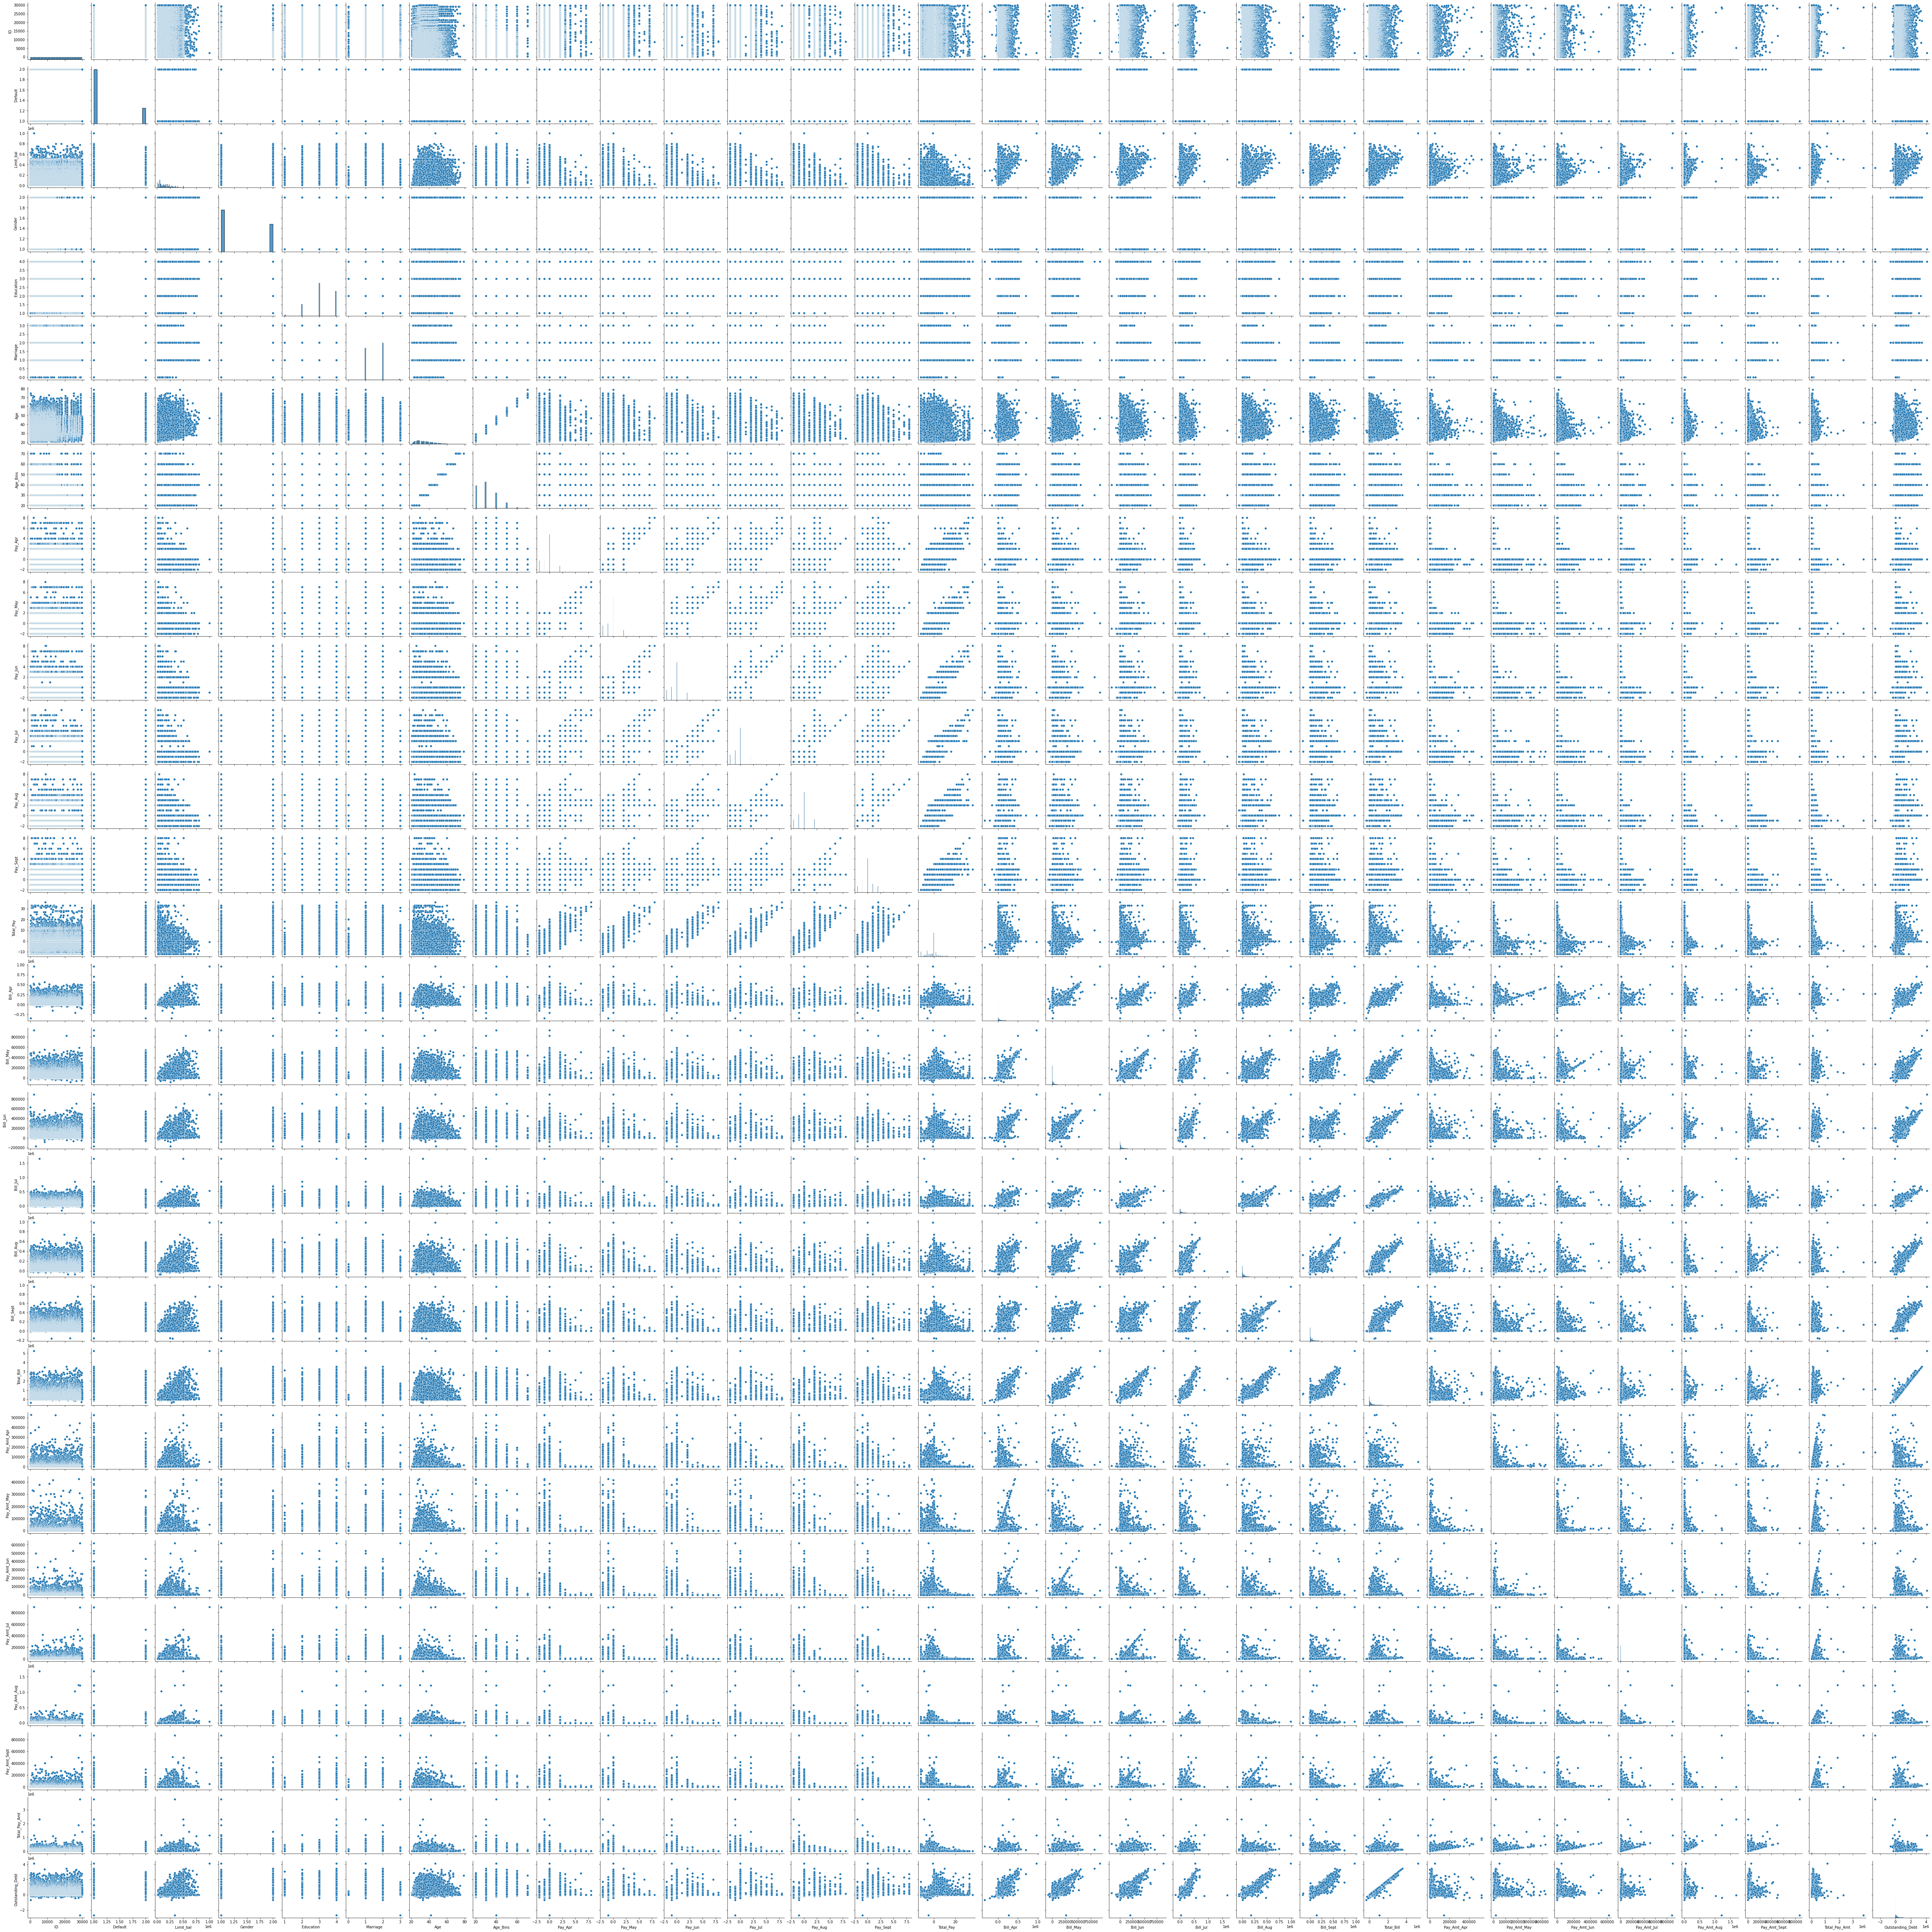

In [8]:
#scatterplots of relationships between all variables
sns.pairplot(credit)

In [9]:
#creating series of bill amounts to be able to plot billing over time
apr_bsum = credit['Bill_Apr'].sum()
may_bsum = credit['Bill_May'].sum()
jun_bsum = credit['Bill_Jun'].sum()
jul_bsum = credit['Bill_Jul'].sum()
aug_bsum = credit['Bill_Aug'].sum()
sept_bsum = credit['Bill_Sept'].sum()
bill_sum = (apr_bsum, may_bsum, jun_bsum, jul_bsum, aug_bsum, sept_bsum)
bill_sum = np.array(bill_sum)
print(bill_sum)

[1166152812 1209342029 1297888469 1410394644 1475372255 1536699927]


In [10]:
#creating series of payment amounts to be able to plot payment over time
apr_psum = credit['Pay_Amt_Apr'].sum()
may_psum = credit['Pay_Amt_May'].sum()
jun_psum = credit['Pay_Amt_Jun'].sum()
jul_psum = credit['Pay_Amt_Jul'].sum()
aug_psum = credit['Pay_Amt_Aug'].sum()
sept_psum = credit['Pay_Amt_Sept'].sum()
pay_sum = (apr_psum, may_psum, jun_psum, jul_psum, aug_psum, sept_psum)
pay_sum = np.array(pay_sum)
print(pay_sum)

[156465077 143981629 144782306 156770445 177634905 169907415]


C:\Users\jryba\AppData\Local\Temp\ipykernel_16700\1484131293.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  monthly.set_yticklabels(['{:,.0f}'.format(y) + 'M' for y in monthly.get_yticks()/1000000])


Text(0.5, 0, 'Payment Period (Months)')

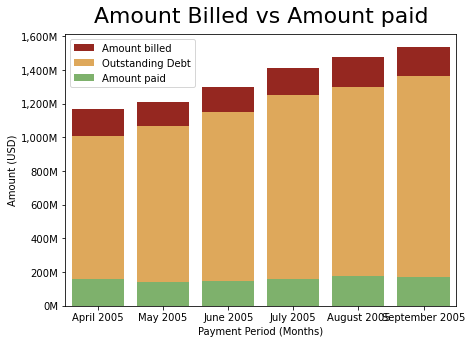

In [11]:
months = ['April 2005', 'May 2005','June 2005', 'July 2005', 'August 2005', 'September 2005']
monthly = plt.subplots(figsize=(7,5))
monthly = sns.barplot(x= months, y=bill_sum, color='#a9160c', errwidth=0, label='Amount billed')
monthly = sns.barplot(x=months, y=(bill_sum-pay_sum), color='#f4ac45', label='Outstanding Debt')
monthly = sns.barplot(x=months, y=pay_sum, color='#78BC61', errwidth=0, label='Amount paid')
monthly.legend()
monthly.set_yticklabels(['{:,.0f}'.format(y) + 'M' for y in monthly.get_yticks()/1000000])
plt.title("Amount Billed vs Amount paid", y=1.02, fontsize=22)
plt.ylabel('Amount (USD)')
plt.xlabel('Payment Period (Months)')

C:\Users\jryba\AppData\Local\Temp\ipykernel_16700\2466095492.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  monthly.set_yticklabels(ylabels)


Text(0.5, 0, 'Payment Period (Months)')

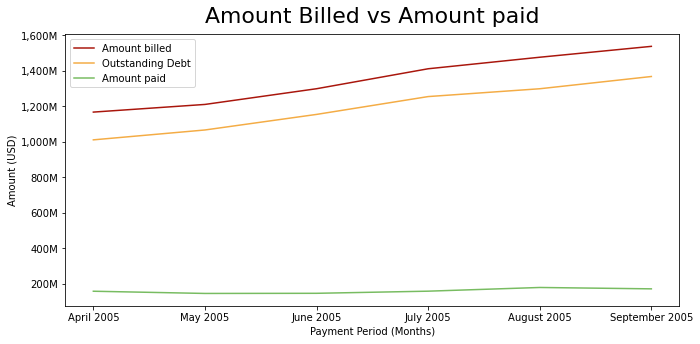

In [12]:
monthly = plt.subplots(figsize=(11,5))
monthly = sns.lineplot(x= months, y=bill_sum, color='#a9160c', label='Amount billed')
monthly = sns.lineplot(x=months, y=(bill_sum-pay_sum), color='#f4ac45', label='Outstanding Debt')
monthly = sns.lineplot(x=months, y=pay_sum, color='#78BC61', label='Amount paid')
monthly.legend()
ylabels = ['{:,.0f}'.format(y) + 'M' for y in monthly.get_yticks()/1000000]
monthly.set_yticklabels(ylabels)
plt.title("Amount Billed vs Amount paid", y=1.02, fontsize=22)
plt.ylabel('Amount (USD)')
plt.xlabel('Payment Period (Months)')

Making time series graphs to compare the amounts billed and paid over time. There seems to be very little payment compared to the billing amount. This would be very concerning for Credit One. 

I made separate tables adding all of the monthly payment columns in order to make these graphs. There's probably a way to make them without needing to, but this was the simplest way I could find.

separating out the people who defaulted and the people who didn't.

In [13]:
#dataframe of people who defaulted
defaulted = credit.loc[credit['Default']==2]
defaulted.describe()

ID  Default      Limit_bal       Gender    Education  \
count   6636.000000   6636.0    6636.000000  6636.000000  6636.000000   
mean   14773.781947      2.0  130109.656420     1.432942     3.110458   
std     8571.616622      0.0  115378.540571     0.495520     0.707803   
min        1.000000      2.0   10000.000000     1.000000     1.000000   
25%     7408.500000      2.0   50000.000000     1.000000     3.000000   
50%    14758.500000      2.0   90000.000000     1.000000     3.000000   
75%    21831.750000      2.0  200000.000000     2.000000     4.000000   
max    30000.000000      2.0  740000.000000     2.000000     4.000000   

          Marriage          Age     Age_Bins      Pay_Apr      Pay_May  \
count  6636.000000  6636.000000  6636.000000  6636.000000  6636.000000   
mean      1.528029    35.725738    31.125678     0.112116     0.167872   
std       0.525433     9.693438    10.152501     1.485757     1.482833   
min       0.000000    21.000000    20.000000    -2.000000    -2.000000   
25%       1.000000    28.000000    20.000000    -1.000000    -1.000000   
50%       2.000000    34.000000    30.000000     0.000000     0.000000   
75%       2.000000    42.000000    40.000000     0.000000     0.000000   
max       3.000000    75.000000    70.000000     8.000000     8.000000   

           Pay_Jun      Pay_Jul      Pay_Aug     Pay_Sept    Total_Pay  \
count  6636.000000  6636.000000  6636.000000  6636.000000  6636.000000   
mean      0.254521     0.362116     0.458258     0.668174     2.023056   
std       1.508535     1.499401     1.502243     1.383252     7.458758   
min      -2.000000    -2.000000    -2.000000    -2.000000   -12.000000   
25%      -1.000000    -1.000000     0.000000     0.000000    -3.000000   
50%       0.000000     0.000000     0.000000     1.000000     2.000000   
75%       2.000000     2.000000     2.000000     2.000000     7.000000   
max       8.000000     8.000000     7.000000     8.000000    36.000000   

            Bill_Apr       Bill_May       Bill_Jun       Bill_Jul  \
count    6636.000000    6636.000000    6636.000000    6636.000000   
mean    38271.435503   39540.190476   42036.950573   45181.598855   
std     59579.674268   61424.695949   64351.076092   68516.975738   
min   -339603.000000  -53007.000000  -65167.000000  -61506.000000   
25%      1150.000000    1502.750000    2141.500000    2500.000000   
50%     18028.500000   18478.500000   19119.500000   19834.500000   
75%     47424.000000   47853.000000   50175.750000   54733.750000   
max    514975.000000  547880.000000  548020.000000  578971.000000   

            Bill_Aug      Bill_Sept    Total_Bill    Pay_Amt_Apr  \
count    6636.000000    6636.000000  6.636000e+03    6636.000000   
mean    47283.617842   48509.162297  2.608230e+05    3441.482068   
std     71651.030364   73782.067220  3.857705e+05   13464.005894   
min    -17710.000000   -6676.000000 -3.362590e+05       0.000000   
25%      2694.000000    2987.750000  2.275775e+04       0.000000   
50%     20300.500000   20185.000000  1.186880e+05    1000.000000   
75%     57919.750000   59626.500000  3.079915e+05    2974.500000   
max    581775.000000  613860.000000  3.127490e+06  345293.000000   

         Pay_Amt_May    Pay_Amt_Jun    Pay_Amt_Jul    Pay_Amt_Aug  \
count    6636.000000    6636.000000    6636.000000    6636.000000   
mean     3219.139542    3155.626733    3367.351567    3388.649638   
std     11944.731175   11191.973162   12959.624486   11737.986064   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%      1000.000000    1000.000000    1222.000000    1533.500000   
75%      3000.000000    2939.250000    3000.000000    3309.750000   
max    332000.000000  432130.000000  508229.000000  358689.000000   

        Pay_Amt_Sept  Total_Pay_Amt  Outstanding_Debt  
count    6636.000000    6636.000000      6.636000e+03  
mean     3397.044153   19969.293701      2.408537e+05  


In [14]:
#dataframe of people who did not default
not_defaulted = credit.loc[credit['Default']==1]
not_defaulted.describe()

ID  Default       Limit_bal        Gender     Education  \
count  23364.000000  23364.0    23364.000000  23364.000000  23364.000000   
mean   15064.893982      1.0   178099.726074      1.385850      3.171161   
std     8684.552145      0.0   131628.359660      0.486806      0.754065   
min        3.000000      1.0    10000.000000      1.000000      1.000000   
25%     7526.750000      1.0    70000.000000      1.000000      3.000000   
50%    15073.500000      1.0   150000.000000      1.000000      3.000000   
75%    22637.250000      1.0   250000.000000      2.000000      4.000000   
max    29997.000000      1.0  1000000.000000      2.000000      4.000000   

           Marriage           Age      Age_Bins       Pay_Apr       Pay_May  \
count  23364.000000  23364.000000  23364.000000  23364.000000  23364.000000   
mean       1.558637     35.417266     30.780260     -0.405624     -0.389488   
std        0.520794      9.077355      9.616798      1.005930      0.977591   
min        0.000000     21.000000     20.000000     -2.000000     -2.000000   
25%        1.000000     28.000000     20.000000     -1.000000     -1.000000   
50%        2.000000     34.000000     30.000000      0.000000      0.000000   
75%        2.000000     41.000000     40.000000      0.000000      0.000000   
max        3.000000     79.000000     70.000000      7.000000      7.000000   

            Pay_Jun       Pay_Jul       Pay_Aug      Pay_Sept     Total_Pay  \
count  23364.000000  23364.000000  23364.000000  23364.000000  23364.000000   
mean      -0.355633     -0.316256     -0.301917     -0.211222     -1.980140   
std        1.013162      1.048378      1.035191      0.952464      5.024704   
min       -2.000000     -2.000000     -2.000000     -2.000000    -12.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -5.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      8.000000      8.000000      8.000000     33.000000   

            Bill_Apr       Bill_May       Bill_Jun      Bill_Jul  \
count   23364.000000   23364.000000   23364.000000  2.336400e+04   
mean    39042.268704   40530.445343   43611.165254  4.753337e+04   
std     59547.015717   60617.268112   64324.796730  6.957666e+04   
min   -209051.000000  -81334.000000 -170000.000000 -1.572640e+05   
25%      1265.500000    1823.000000    2360.000000  2.769750e+03   
50%     16679.000000   17998.000000   19000.000000  2.020250e+04   
75%     49842.500000   51135.250000   55988.000000  6.189400e+04   
max    961664.000000  927171.000000  891586.000000  1.664089e+06   

            Bill_Aug      Bill_Sept    Total_Bill    Pay_Amt_Apr  \
count   23364.000000   23364.000000  2.336400e+04   23364.000000   
mean    49717.435670   51994.227273  2.724289e+05    5719.371769   
std     71029.946709   73577.606694  3.777519e+05   18792.950473   
min    -69777.000000 -165580.000000 -1.254800e+05       0.000000   
25%      3055.000000    3677.250000  3.013425e+04     300.000000   
50%     21660.500000   23119.500000  1.286605e+05    1706.000000   
75%     65686.000000   69027.000000  3.501940e+05    4545.000000   
max    983931.000000  964511.000000  5.263883e+06  528666.000000   

         Pay_Amt_May    Pay_Amt_Jun    Pay_Amt_Jul   Pay_Amt_Aug  \
count   23364.000000   23364.000000   23364.000000  2.336400e+04   
mean     5248.220296    5300.529319    5753.496833  6.640465e+03   
std     16071.667860   16689.778060   18684.255937  2.530226e+04   
min         0.000000       0.000000       0.000000  0.000000e+00   
25%       369.000000     390.000000     600.000000  1.005000e+03   
50%      1765.000000    1734.000000    2000.000000  2.247500e+03   
75%      4600.000000    4602.000000    5000.000000  5.311250e+03   
max    426529.000000  621000.000000  896040.000000  1.684259e+06   

        Pay_Amt_Sept  Total_Pay_Amt  Outstanding_Debt  
count   23364

In [15]:
#creating billing series of people who defaulted
apr_bsum2 = defaulted['Bill_Apr'].sum()
may_bsum2 = defaulted['Bill_May'].sum()
jun_bsum2 = defaulted['Bill_Jun'].sum()
jul_bsum2 = defaulted['Bill_Jul'].sum()
aug_bsum2 = defaulted['Bill_Aug'].sum()
sept_bsum2 = defaulted['Bill_Sept'].sum()
bill_sum2 = (apr_bsum2, may_bsum2, jun_bsum2, jul_bsum2, aug_bsum2, sept_bsum2)
bill_sum2 = np.array(bill_sum2)
print(bill_sum2)

[253969246 262388704 278957204 299825090 313774088 321906801]


In [16]:
#creating payment series of people who defaulted
apr_psum2 = defaulted['Pay_Amt_Apr'].sum()
may_psum2= defaulted['Pay_Amt_May'].sum()
jun_psum2 = defaulted['Pay_Amt_Jun'].sum()
jul_psum2 = defaulted['Pay_Amt_Jul'].sum()
aug_psum2 = defaulted['Pay_Amt_Aug'].sum()
sept_psum2 = defaulted['Pay_Amt_Sept'].sum()
pay_sum2 = (apr_psum2, may_psum2, jun_psum2, jul_psum2, aug_psum2, sept_psum2)
pay_sum2 = np.array(pay_sum2)
print(pay_sum2)

[22837675 21362210 20940739 22345745 22487079 22542785]


In [17]:
#payment series - did not default
apr_psum3 = not_defaulted['Pay_Amt_Apr'].sum()
may_psum3 = not_defaulted['Pay_Amt_May'].sum()
jun_psum3 = not_defaulted['Pay_Amt_Jun'].sum()
jul_psum3 = not_defaulted['Pay_Amt_Jul'].sum()
aug_psum3 = not_defaulted['Pay_Amt_Aug'].sum()
sept_psum3 = not_defaulted['Pay_Amt_Sept'].sum()
pay_sum3 = (apr_psum3, may_psum3, jun_psum3, jul_psum3, aug_psum3, sept_psum3)
pay_sum3 = np.array(pay_sum3)
print(pay_sum3)

[133627402 122619419 123841567 134424700 155147826 147364630]


In [18]:
#payment series - defaulted
apr_bsum3 = not_defaulted['Bill_Apr'].sum()
may_bsum3 = not_defaulted['Bill_May'].sum()
jun_bsum3 = not_defaulted['Bill_Jun'].sum()
jul_bsum3 = not_defaulted['Bill_Jul'].sum()
aug_bsum3 = not_defaulted['Bill_Aug'].sum()
sept_bsum3 = not_defaulted['Bill_Sept'].sum()
bill_sum3 = (apr_bsum3, may_bsum3, jun_bsum3, jul_bsum3, aug_bsum3, sept_bsum3)
bill_sum3 = np.array(bill_sum3)
print(bill_sum3)

[ 912183566  946953325 1018931265 1110569554 1161598167 1214793126]


C:\Users\jryba\AppData\Local\Temp\ipykernel_16700\4228203591.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  monthly.set_yticklabels(ylabels)


Text(0.5, 0, 'Payment Period (Months)')

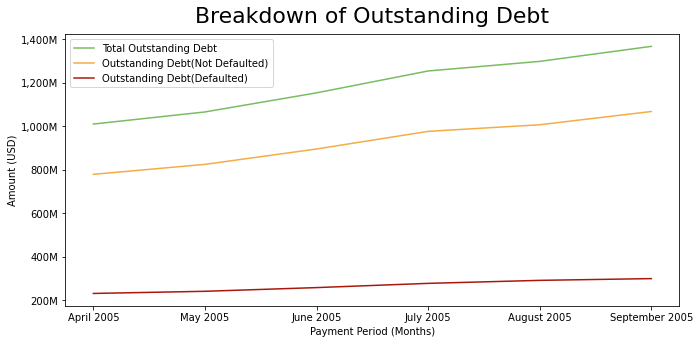

In [19]:
#Plotting difference in outstanding debt in people who defaulted and those who didn't 
monthly = plt.subplots(figsize=(11,5))
monthly = sns.lineplot(x=months, y=(bill_sum-pay_sum), color='#78BC61', label='Total Outstanding Debt')
monthly = sns.lineplot(x=months, y=(bill_sum3-pay_sum3), color='#f4ac45', label='Outstanding Debt(Not Defaulted)')
monthly = sns.lineplot(x=months, y=(bill_sum2-pay_sum2), color='#a9160c', label='Outstanding Debt(Defaulted)')
monthly.legend()
ylabels = ['{:,.0f}'.format(y) + 'M' for y in monthly.get_yticks()/1000000]
monthly.set_yticklabels(ylabels)
plt.title("Breakdown of Outstanding Debt", y=1.02, fontsize=22)
plt.ylabel('Amount (USD)')
plt.xlabel('Payment Period (Months)')

Text(0.5, 1.0, 'Default by Percent')

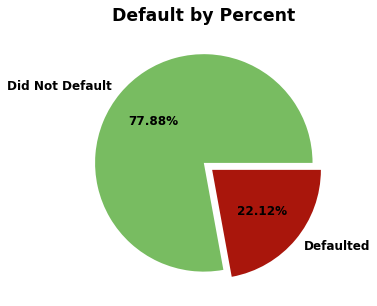

In [20]:
#percentage of people who defaulted vs. those who didn't
fig, ax = plt.subplots(figsize=(5,5))
plt.pie(x=credit['Default'].value_counts(), colors=['#78BC61','#a9160c'], labels=['Did Not Default','Defaulted'], autopct='%.2f%%', 
           textprops={'size':'large','fontweight':'bold'}, explode=(0,0.1))
ax.set_title('Default by Percent',{'size':'xx-large','fontweight':'bold'})

Percentage of people who have defaulted. It's over 1 in 5, which is a lot.

([<matplotlib.patches.Wedge at 0x1d17797c790>,
 [Text(-0.8394585429297966, 0.7108511480627875, 'Did Not Default'),
  Text(0.9157729559234139, -0.7754739797048597, 'Defaulted')],
 [Text(-0.4578864779617072, 0.3877369898524295, '77.63%'),
  Text(0.5342008909553247, -0.4523598214945014, '22.37%')])

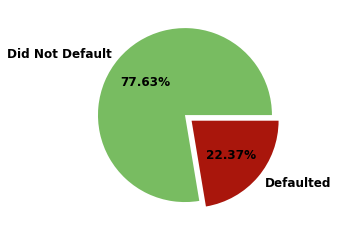

In [21]:
#debt percentage of people who defaulted vs people who didn't
out_debt1 = defaulted['Outstanding_Debt'].sum()
out_debt2= not_defaulted['Outstanding_Debt'].sum()
out_debt = out_debt2, out_debt1
plt.pie(x=out_debt, colors=['#78BC61','#a9160c'], labels=['Did Not Default','Defaulted'], autopct='%.2f%%', 
           textprops={'size':'large','fontweight':'bold'}, explode=(0,0.1))

The percent of people who defaulted is about the same as their debt. So no distinction of debt between those categories. Even so, the majority of debt is from those who did not default

Getting percentages of demographic data, namely gender, marital status, age, and education. Will later compare with only the values in default.

Text(0.5, 1.0, 'Defaulted')

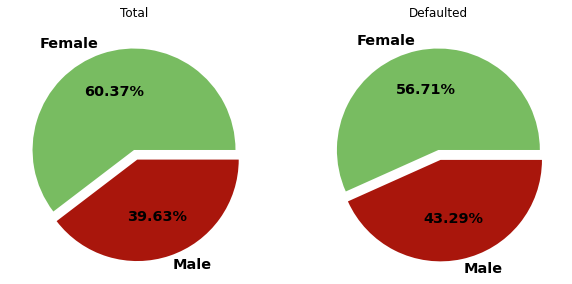

In [22]:
#graphing gender percentage demographics
fig, ax = plt.subplots(1,2,sharex=False, sharey=False, figsize=(10,5))
ax[0].pie(x=credit['Gender'].value_counts(), colors=['#78BC61','#a9160c'], labels=['Female','Male'], autopct='%.2f%%', 
           textprops={'size':'x-large','fontweight':'bold'}, explode=(0,0.1))
ax[0].set_title('Total')
ax[1].pie(x=defaulted['Gender'].value_counts(), colors=['#78BC61','#a9160c'], labels=['Female','Male'], autopct='%.2f%%', 
           textprops={'size':'x-large','fontweight':'bold'}, explode=(0,0.1))
ax[1].set_title('Defaulted')

There was a slightly higher percentage of males in the defaulted category, but more females overall.

Text(0.5, 1.0, 'Defaulted')

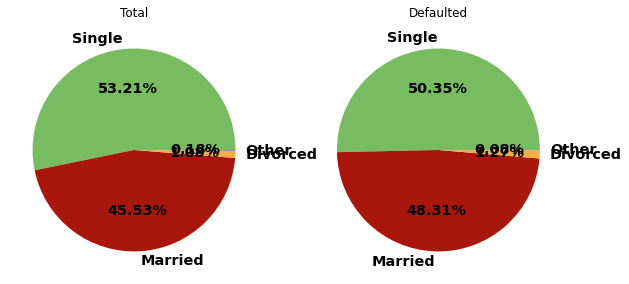

In [23]:
#Marital Status percentage
fig, ax = plt.subplots(1,2,sharex=False, sharey=False, figsize=(10,5))
ax[0].pie(x=credit['Marriage'].value_counts(), colors=['#78BC61','#a9160c','#f4ac45','#b287a3'], labels=['Single','Married','Divorced','Other'], autopct='%.2f%%', 
           textprops={'size':'x-large','fontweight':'bold'})
ax[0].set_title('Total')
ax[1].pie(x=defaulted['Marriage'].value_counts(), colors=['#78BC61','#a9160c','#f4ac45','#b287a3'], labels=['Single','Married','Divorced','Other'], autopct='%.2f%%', 
           textprops={'size':'x-large','fontweight':'bold'})
ax[1].set_title('Defaulted')

There was actually a smaller percentage of single people defaulting. Married people had a higher percent. Divorced and other appear the same

In [24]:
#counting age bins as reference to make sure the right labels are in the right group
credit['Age_Bins'].value_counts()

30    11238
20     9618
40     6464
50     2341
60      314
70       25
Name: Age_Bins, dtype: int64

C:\Users\jryba\AppData\Local\Temp\ipykernel_16700\4268206313.py:12: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax[2].legend(not_defaulted['Age_Bins'].value_counts(), labels=['30s','20s','40s','50s','60s','70s'])


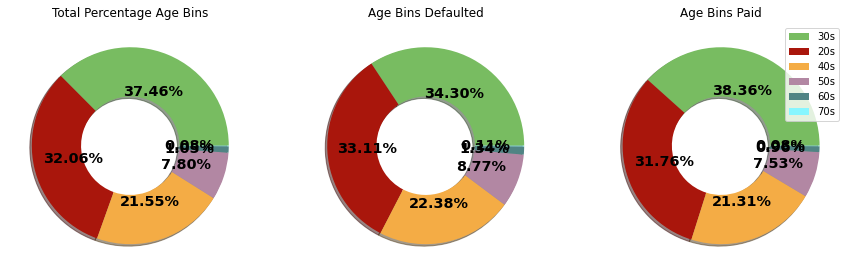

In [25]:
#Age demographics
fig, ax = plt.subplots(1,3,sharex=False, sharey=False, figsize=(15, 5))
ax[0].pie(x=credit['Age_Bins'].value_counts(), autopct='%.2f%%',wedgeprops=dict(width=.5), colors=['#78BC61','#a9160c','#f4ac45', '#b287a3', '#508484', '#87F6FF'] ,
          textprops={'size':'x-large','fontweight':'bold'}, shadow=True)
ax[0].set_title('Total Percentage Age Bins')
ax[1].pie(x=defaulted['Age_Bins'].value_counts(), autopct='%.2f%%', wedgeprops=dict(width=.5),
           colors=['#78BC61','#a9160c','#f4ac45','#b287a3', '#508484', '#87F6FF'], textprops={'size':'x-large','fontweight':'bold'}, shadow=True)
ax[1].set_title('Age Bins Defaulted')
ax[2].pie(x=not_defaulted['Age_Bins'].value_counts(), autopct='%.2f%%', wedgeprops=dict(width=.5),
           colors=['#78BC61','#a9160c','#f4ac45','#b287a3','#508484', '#87F6FF'], textprops={'size':'x-large','fontweight':'bold'}, shadow=True)
ax[2].set_title('Age Bins Paid')
ax[2].legend(not_defaulted['Age_Bins'].value_counts(), labels=['30s','20s','40s','50s','60s','70s'])

Text(0.5, 1.0, 'Defaulted')

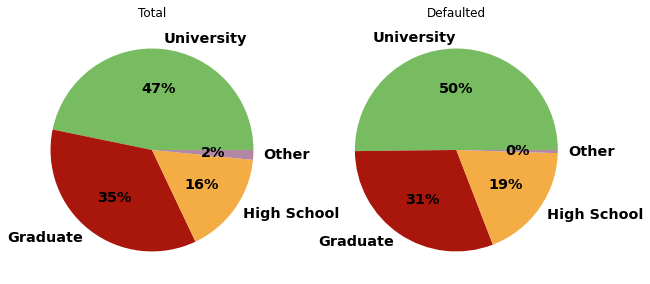

In [26]:
#Education demographics
fig, ax = plt.subplots(1,2,sharex=False, sharey=False, figsize=(10,5))
ax[0].pie(x=credit['Education'].value_counts(), colors=['#78BC61','#a9160c','#f4ac45','#b287a3'], labels=['University','Graduate','High School','Other'],autopct='%.0f%%', 
           textprops={'size':'x-large','fontweight':'bold'})
ax[0].set_title('Total')
ax[1].pie(x=defaulted['Education'].value_counts(), colors=['#78BC61','#a9160c','#f4ac45','#b287a3'], labels=['University','Graduate','High School','Other'],autopct='%.0f%%', 
           textprops={'size':'x-large','fontweight':'bold'})
ax[1].set_title('Defaulted')

University high school graduates seem more likely to default. Grad school graduates less likely

<AxesSubplot:xlabel='Outstanding_Debt', ylabel='Limit_bal'>

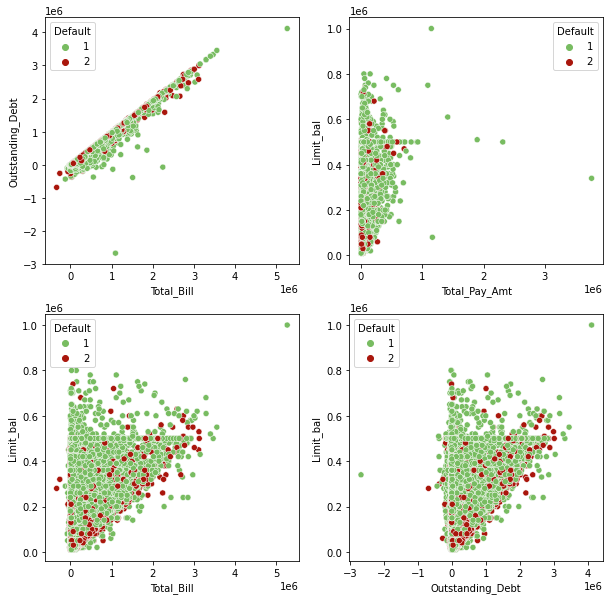

In [27]:
#graphing limit balance comparisons
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=False, sharey=False, figsize=(10,10))
sns.scatterplot(y=credit['Outstanding_Debt'], x=credit['Total_Bill'], hue=credit['Default'], palette=['#78BC61','#a9160c'], ax=ax1)
sns.scatterplot(y=credit['Limit_bal'], x=credit['Total_Pay_Amt'], hue=credit['Default'], palette=['#78BC61','#a9160c'], ax=ax2)
sns.scatterplot(y=credit['Limit_bal'], x=credit['Total_Bill'], hue=credit['Default'], palette=['#78BC61','#a9160c'], ax=ax3)
sns.scatterplot(y=credit['Limit_bal'], x=credit['Outstanding_Debt'], hue=credit['Default'], palette=['#78BC61','#a9160c'], ax=ax4)


Comparing the total bill and outstanding balance to the limit balance. They look almost identical, probably because the total bill and outstainding balance are highly correlated. Makes sense if enough people aren't paying their bills.

The total pay amount is pretty uniformly low, no matter the limit balance

It took me a bit to make the graphs in the same cell, but I think it's better to compare. 

<AxesSubplot:xlabel='Total_Bill', ylabel='Count'>

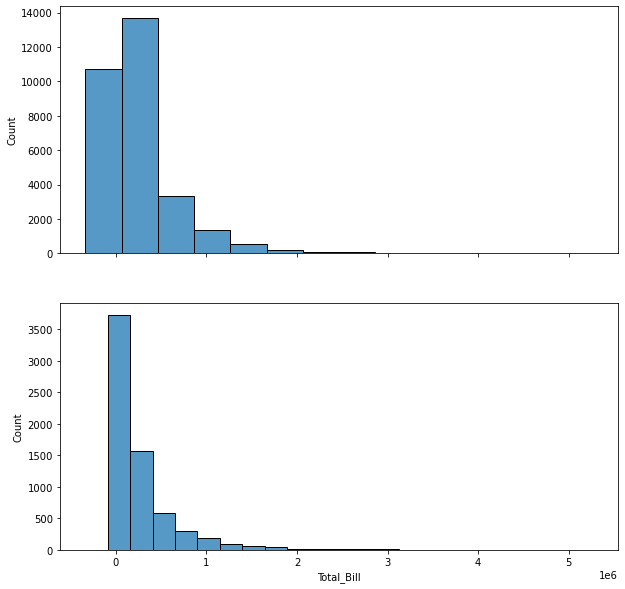

In [28]:
#total bill grpahics
fig,(ax1,ax2)= plt.subplots(2,1, sharex=True, sharey=False, figsize=(10,10))
sns.histplot(x=credit['Total_Bill'], ax=ax1, bins=14)
sns.histplot(x=defaulted['Total_Bill'], ax=ax2, bins=14)

Surprisingly, people with a lower bill were more likely to default.

<AxesSubplot:xlabel='Total_Pay', ylabel='Count'>

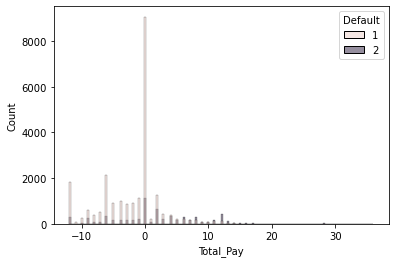

In [29]:
#total bill grpahics
sns.histplot(x=credit['Total_Pay'], hue=credit['Default'])


Most people did not have a delay on their credit. If they did, they were more likely to default.

In [30]:
#checking out some outliers
credit.loc[credit['Total_Pay_Amt'] >3000000]

ID  Default  Limit_bal  Gender  Education  Marriage  Age  Age_Bins  \
28716  28717        1     340000       1          4         3   42        40   

       Pay_Apr  Pay_May  Pay_Jun  Pay_Jul  Pay_Aug  Pay_Sept  Total_Pay  \
28716        0       -1       -1       -1       -1        -1         -5   

       Bill_Apr  Bill_May  Bill_Jun  Bill_Jul  Bill_Aug  Bill_Sept  \
28716    270237    265431    205931     34402    176743     139808   

       Total_Bill  Pay_Amt_Apr  Pay_Amt_May  Pay_Amt_Jun  Pay_Amt_Jul  \
28716     1092552       145000        20000       621000       889043   

       Pay_Amt_Aug  Pay_Amt_Sept  Total_Pay_Amt  Outstanding_Debt  
28716      1215471        873552        3764066          -2671514

In [31]:
credit.loc[credit['Outstanding_Debt'] < -1000000]

ID  Default  Limit_bal  Gender  Education  Marriage  Age  Age_Bins  \
28716  28717        1     340000       1          4         3   42        40   

       Pay_Apr  Pay_May  Pay_Jun  Pay_Jul  Pay_Aug  Pay_Sept  Total_Pay  \
28716        0       -1       -1       -1       -1        -1         -5   

       Bill_Apr  Bill_May  Bill_Jun  Bill_Jul  Bill_Aug  Bill_Sept  \
28716    270237    265431    205931     34402    176743     139808   

       Total_Bill  Pay_Amt_Apr  Pay_Amt_May  Pay_Amt_Jun  Pay_Amt_Jul  \
28716     1092552       145000        20000       621000       889043   

       Pay_Amt_Aug  Pay_Amt_Sept  Total_Pay_Amt  Outstanding_Debt  
28716      1215471        873552        3764066          -2671514

Is this a computer error? Why'd this dude pay so much? It's 10x his credit limit.

In [32]:
credit.loc[credit['Limit_bal'] > 900000]

ID  Default  Limit_bal  Gender  Education  Marriage  Age  Age_Bins  \
2197  2198        1    1000000       1          4         1   47        40   

      Pay_Apr  Pay_May  Pay_Jun  Pay_Jul  Pay_Aug  Pay_Sept  Total_Pay  \
2197        0        0       -1        0        0         0         -1   

      Bill_Apr  Bill_May  Bill_Jun  Bill_Jul  Bill_Aug  Bill_Sept  Total_Bill  \
2197    961664    927171    891586    535020    983931     964511     5263883   

      Pay_Amt_Apr  Pay_Amt_May  Pay_Amt_Jun  Pay_Amt_Jul  Pay_Amt_Aug  \
2197        50256        50000        50000       896040        50723   

      Pay_Amt_Sept  Total_Pay_Amt  Outstanding_Debt  
2197         50784        1147803           4116080

Why is this guy's credit limit so high? It doesn't appear to be in error, the guy is spending large amounts and paying some of it off.

<AxesSubplot:xlabel='Limit_bal', ylabel='Count'>

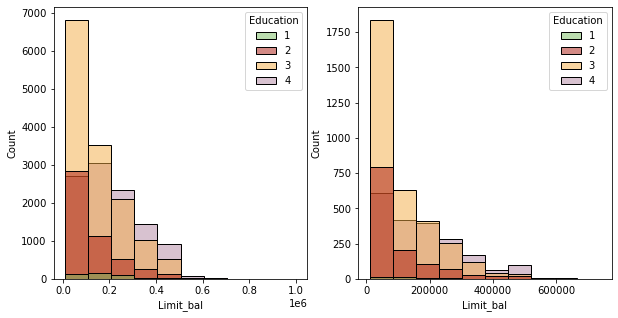

In [33]:
#education and limit balance
fig,(ax1,ax2)= plt.subplots(1,2, sharex=False, sharey=False, figsize=(10,5))
sns.histplot(x=credit['Limit_bal'], hue=credit['Education'], ax=ax1, bins=10, palette=['#78BC61','#a9160c','#f4ac45','#b287a3'])
sns.histplot(x=defaulted['Limit_bal'], hue=defaulted['Education'], ax=ax2, bins=10, palette=['#78BC61','#a9160c','#f4ac45','#b287a3'])

The higher the education, the higher the number

Since it's a count of a subset, I'm more looking at the general shape of the graphs than the scale. Lower limit balances were more likely to default.

<AxesSubplot:xlabel='Limit_bal', ylabel='Count'>

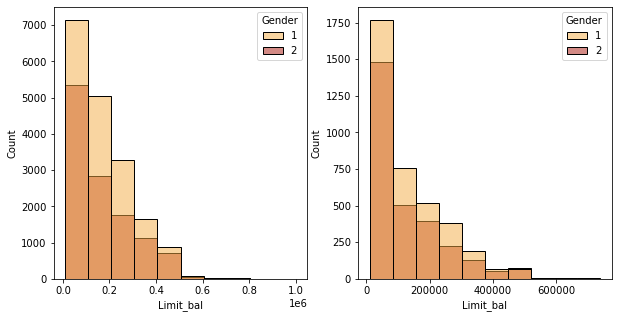

In [34]:
#gender and limit balance
fig,(ax1,ax2)= plt.subplots(1,2, sharex=False, sharey=False, figsize=(10,5))
sns.histplot(x=credit['Limit_bal'], hue=credit['Gender'], ax=ax1, bins=10, palette=['#f4ac45','#a9160c'])
sns.histplot(x=defaulted['Limit_bal'], hue=defaulted['Gender'], ax=ax2, bins=10, palette=['#f4ac45','#a9160c'])

In [35]:
credit['Gender'].value_counts()

1    18112
2    11888
Name: Gender, dtype: int64

Females are 1, males are 2

A bit higher number of females in all categories, but comparatively more even numbers defaulted. This correlates with the pie charts above.

<AxesSubplot:xlabel='Age', ylabel='Count'>

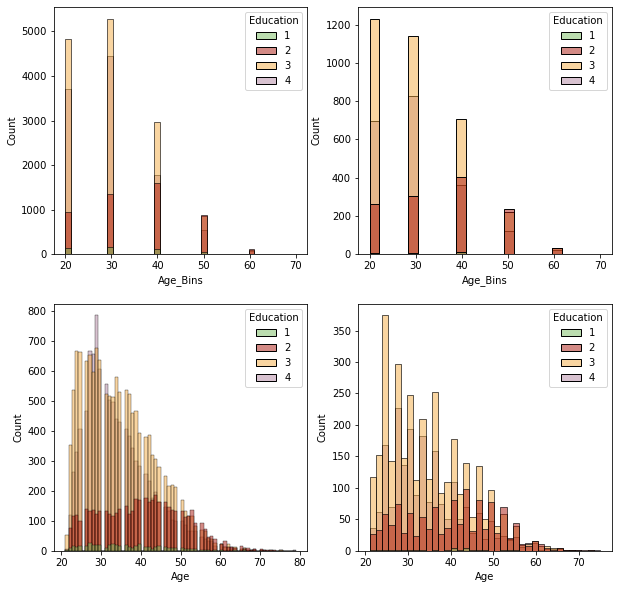

In [36]:
#Age and education
fig,((ax1,ax2),(ax3,ax4))= plt.subplots(2,2, sharex=False, sharey=False, figsize=(10,10))
sns.histplot(x=credit['Age_Bins'], hue=credit['Education'], ax=ax1, palette=['#78BC61','#a9160c','#f4ac45','#b287a3'])
sns.histplot(x=defaulted['Age_Bins'], hue=defaulted['Education'], ax=ax2, palette=['#78BC61','#a9160c','#f4ac45','#b287a3'])
sns.histplot(x=credit['Age'], hue=credit['Education'], ax=ax3, palette=['#78BC61','#a9160c','#f4ac45','#b287a3'])
sns.histplot(x=defaulted['Age'], hue=defaulted['Education'], ax=ax4, palette=['#78BC61','#a9160c','#f4ac45','#b287a3'])

Getting an idea of age and education demographics

<AxesSubplot:xlabel='Age_Bins', ylabel='Count'>

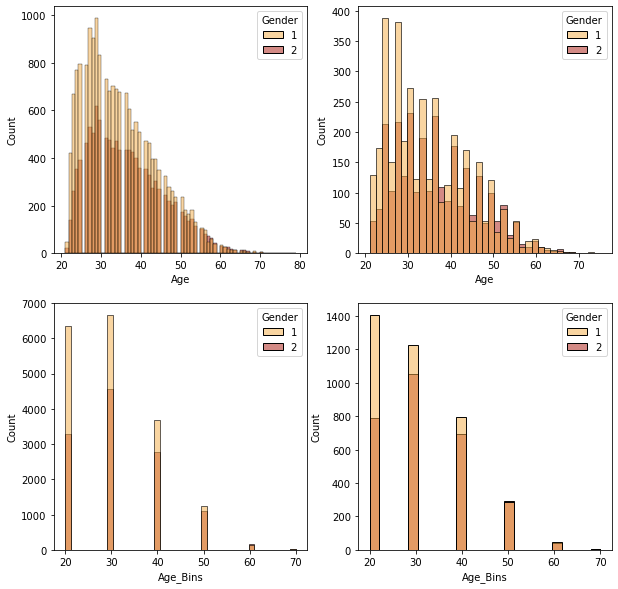

In [37]:
#age and gender
fig,((ax1,ax2),(ax3,ax4))= plt.subplots(2,2, sharex=False, sharey=False, figsize=(10,10))
sns.histplot(x=credit['Age'], hue=credit['Gender'], ax=ax1, palette=['#f4ac45','#a9160c'])
sns.histplot(x=defaulted['Age'], hue=defaulted['Gender'], ax=ax2, palette=['#f4ac45','#a9160c'])
sns.histplot(x=credit['Age_Bins'], hue=credit['Gender'], ax=ax3, palette=['#f4ac45','#a9160c'])
sns.histplot(x=defaulted['Age_Bins'], hue=defaulted['Gender'], ax=ax4, palette=['#f4ac45','#a9160c'])

Age and Age bins basically shows the same thing. Even though there are more people in their 30s opening cards, people in their 20s are more likely to default. 

<AxesSubplot:xlabel='Age_Bins', ylabel='Limit_bal'>

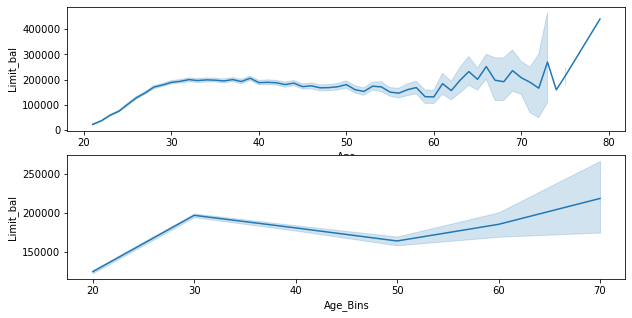

In [38]:
#starting line plots. age and limit balance
colors = ['#78BC61','#a9160c','#f4ac45', '#b287a3', '#508484', '#87F6FF']
fig,(ax1,ax2)= plt.subplots(2,1, sharex=False, sharey=False, figsize=(10,5))
sns.lineplot(x=credit['Age'], y=credit['Limit_bal'], ax=ax1, palette=colors)
sns.lineplot(x=credit['Age_Bins'], y=credit['Limit_bal'], ax=ax2)

There seems to be a nice linear equation here, could use age to help predict limit balance? Gets a bit wild on the older end. Smooth curve is good?

<AxesSubplot:xlabel='Pay_Aug', ylabel='Limit_bal'>

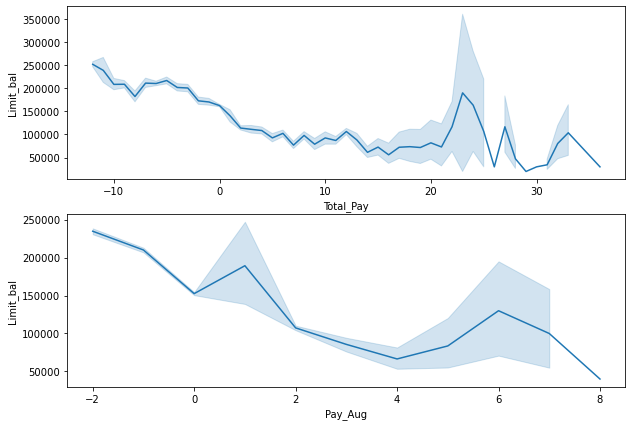

In [39]:
#pay status and limit balance
fig,(ax1,ax2)= plt.subplots(2,1, sharex=False, sharey=False, figsize=(10,7))
sns.lineplot(x=credit['Total_Pay'], y=credit['Limit_bal'], ax=ax1, palette=['#f4ac45','#a9160c'])
sns.lineplot(x=credit['Pay_Aug'], y=credit['Limit_bal'], ax=ax2)

could be something there. Definite negative correlation. A smooth equation is probably better. Chose August because it had the highest negative correlation with Limit Balance in the correlation matrix.

<AxesSubplot:xlabel='Total_Pay_Amt', ylabel='Limit_bal'>

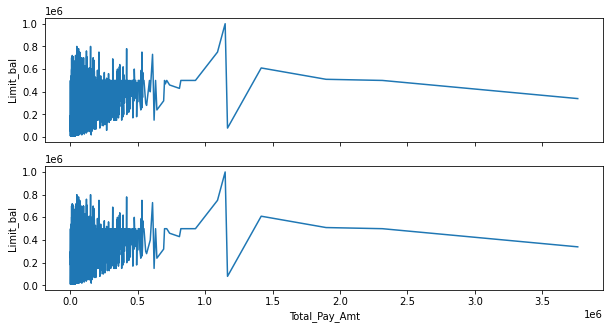

In [40]:
#limit balance and total payment amount
fig,(ax1,ax2)= plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,5))
sns.lineplot(x=credit['Total_Pay_Amt'], y=credit['Limit_bal'], ax=ax1)
sns.lineplot(x=not_defaulted['Total_Pay_Amt'], y=not_defaulted['Limit_bal'], ax=ax2)

Doesn't appear to be a correlation here.

<AxesSubplot:xlabel='Limit_bal', ylabel='Total_Bill'>

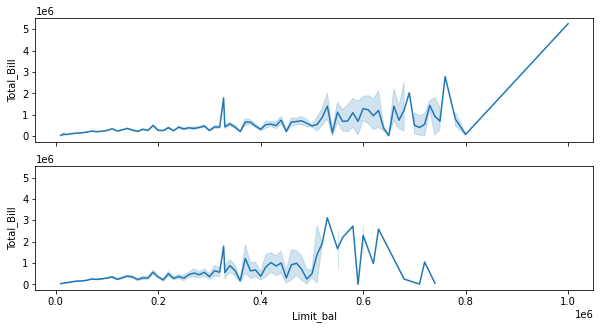

In [41]:
#total bill and limit balance
fig,(ax1,ax2)= plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,5))
sns.lineplot(x=credit['Limit_bal'], y=credit['Total_Bill'], ax=ax1)
sns.lineplot(x=defaulted['Limit_bal'], y=defaulted['Total_Bill'], ax=ax2)

Matches up pretty 1 to 1 with the scatterplots above. Can you do a prediction algorithm based on a triangle?

<AxesSubplot:xlabel='Education', ylabel='Limit_bal'>

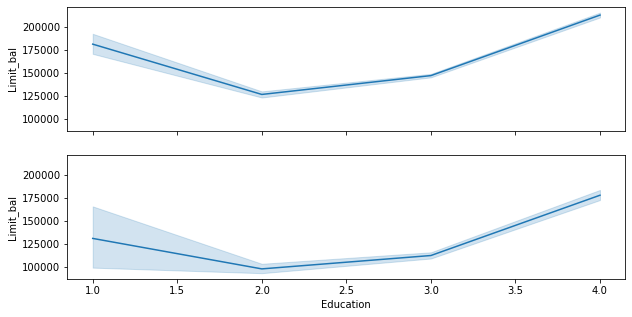

In [42]:
#limit balance and education
fig,(ax1,ax2)= plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,5))
sns.lineplot(x=credit['Education'], y=credit['Limit_bal'], ax=ax1)
sns.lineplot(x=defaulted['Education'], y=defaulted['Limit_bal'], ax=ax2)

Interesting how the 'Other' education column has such a high limit balance. The others make sense. More highly-educated people will probably have higher income, and with higher income comes higher limit balances.

But it's got a nice curve that can be used for prediction purposes.

<AxesSubplot:xlabel='Gender', ylabel='Default'>

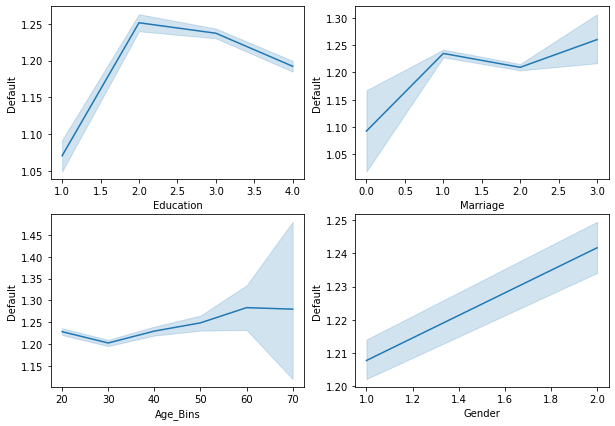

In [43]:
#demographic data and people 
fig,((ax1,ax2),(ax3,ax4))= plt.subplots(2,2, sharex=False, sharey=False, figsize=(10,7))
sns.lineplot(x=credit['Education'], y=credit['Default'], ax=ax1)
sns.lineplot(x=credit['Marriage'], y=credit['Default'], ax=ax2)
sns.lineplot(x=credit['Age_Bins'], y=credit['Default'], ax=ax3)
sns.lineplot(x=credit['Gender'], y=credit['Default'], ax=ax4)

<AxesSubplot:xlabel='Gender', ylabel='Limit_bal'>

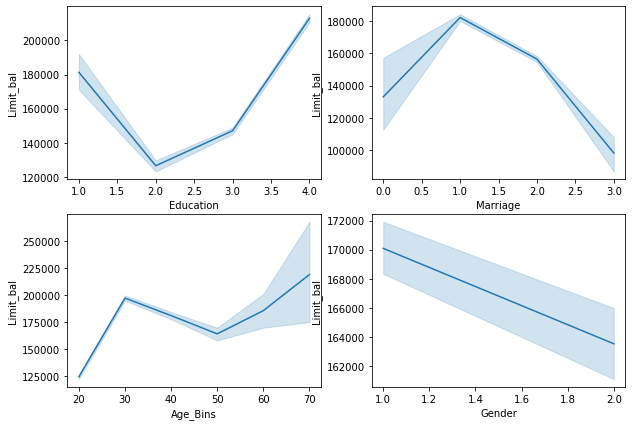

In [44]:
fig,((ax1,ax2),(ax3,ax4))= plt.subplots(2,2, sharex=False, sharey=False, figsize=(10,7))
sns.lineplot(x=credit['Education'], y=credit['Limit_bal'], ax=ax1)
sns.lineplot(x=credit['Marriage'], y=credit['Limit_bal'], ax=ax2)
sns.lineplot(x=credit['Age_Bins'], y=credit['Limit_bal'], ax=ax3)
sns.lineplot(x=credit['Gender'], y=credit['Limit_bal'], ax=ax4)

Age, gender, and education seem to have an inverse curve to their relationships to limit balance. Marriage's is the same until the end

In [45]:
credit.to_csv('credit2.csv')